In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="runs/cnn1") 


In [100]:
Train_df = './brain-tumor-mri-dataset/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 242725.54it/s]


In [101]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [102]:
df_train.head(10)

,filepath,label
0,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
1,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
2,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
3,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
4,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
5,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
6,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
7,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
8,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma
9,./brain-tumor-mri-dataset/Training\glioma\Tr-g...,glioma


In [103]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

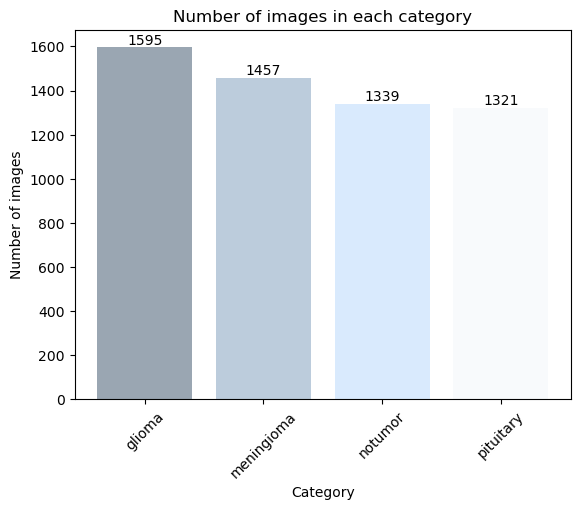

In [104]:
fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [105]:
df_train.sample(5)

,filepath,label
5474,./brain-tumor-mri-dataset/Training\pituitary\T...,pituitary
2129,./brain-tumor-mri-dataset/Training\meningioma\...,meningioma
2760,./brain-tumor-mri-dataset/Training\notumor\Tr-...,notumor
2177,./brain-tumor-mri-dataset/Training\meningioma\...,meningioma
3713,./brain-tumor-mri-dataset/Training\notumor\Tr-...,notumor


In [106]:
Test_df = './brain-tumor-mri-dataset/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 59978.61it/s]


In [107]:
df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [108]:
df_test.sample(5)

,filepath,label
416,./brain-tumor-mri-dataset/Testing\meningioma\T...,meningioma
945,./brain-tumor-mri-dataset/Testing\notumor\Te-n...,notumor
297,./brain-tumor-mri-dataset/Testing\glioma\Te-gl...,glioma
998,./brain-tumor-mri-dataset/Testing\notumor\Te-n...,notumor
345,./brain-tumor-mri-dataset/Testing\meningioma\T...,meningioma


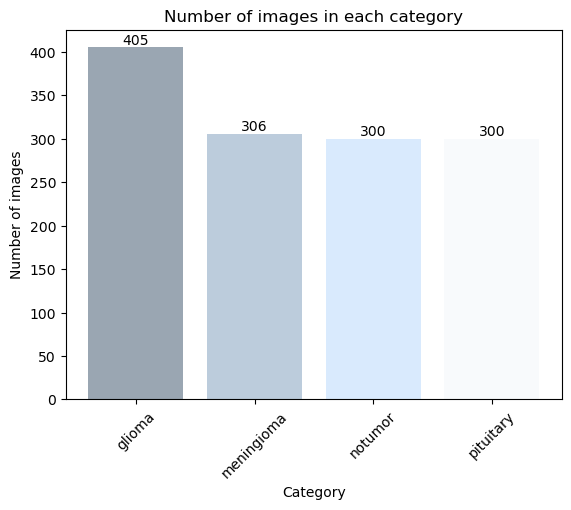

In [109]:
fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [110]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [111]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
valid_ts['label'] = label_encoder.transform(valid_ts['label'])
df_test['label'] = label_encoder.transform(df_test['label'])


In [112]:
img_size = (224, 224) 
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [113]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [114]:
batch_size = 8 

# Create datasets
train_dataset = ImageDataset(df_train, transform=transform)
valid_dataset = ImageDataset(valid_ts, transform=transform)
test_dataset = ImageDataset(df_test, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


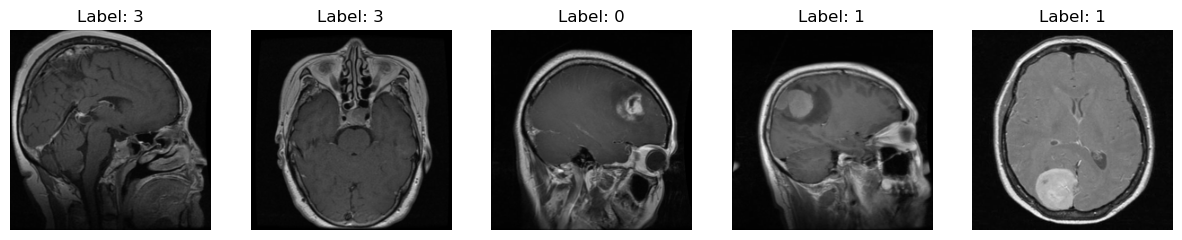

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy and swap axes
    img = img * 0.5 + 0.5  # Unnormalizing (assuming mean=[0.5,0.5,0.5] and std=[0.5,0.5,0.5])
    img = np.clip(img, 0, 1)  # Clip values to be in valid range
    plt.imshow(img)

# Get a batch from test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Visualize images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Display 5 images
for i in range(5):
    axes[i].imshow(images[i].numpy().transpose((1, 2, 0)) * 0.5 + 0.5)
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis("off")

plt.show()


In [116]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding="same"),  # 224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28

            
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),  # 28*28*256
            nn.Linear(256 * 28 * 28, 128),  
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(32, 4) # ['glioma', 'meningioma', 'notumor', 'pituitary']
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # Raw logits, correct for CrossEntropyLoss

model = CNN(input_channels=3)  # RGB images have 3 channels
print(model)


CNN(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=32, ou

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [118]:
num_epochs = 15 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer.add_graph(model, torch.randn(1, 3, 224, 224).to(device))

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Logging loss for each batch into TensorBoard
        writer.add_scalar("Training Loss/Batch", loss.item(), epoch * len(train_loader) + batch_idx)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # Logging loss and accuracy per epoch into TensorBoard
    writer.add_scalar("Training Loss/Epoch", epoch_loss, epoch)
    writer.add_scalar("Training Accuracy/Epoch", epoch_acc, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Close writer after training
writer.close()


Epoch [1/15], Loss: 0.9404, Accuracy: 59.05%
Epoch [2/15], Loss: 0.5479, Accuracy: 80.04%
Epoch [3/15], Loss: 0.4155, Accuracy: 85.21%
Epoch [4/15], Loss: 0.3361, Accuracy: 88.10%
Epoch [5/15], Loss: 0.2648, Accuracy: 90.91%
Epoch [6/15], Loss: 0.2414, Accuracy: 92.07%
Epoch [7/15], Loss: 0.1801, Accuracy: 93.93%
Epoch [8/15], Loss: 0.1587, Accuracy: 94.80%
Epoch [9/15], Loss: 0.1477, Accuracy: 95.10%
Epoch [10/15], Loss: 0.1151, Accuracy: 96.48%
Epoch [11/15], Loss: 0.0957, Accuracy: 97.02%
Epoch [12/15], Loss: 0.1579, Accuracy: 95.66%
Epoch [13/15], Loss: 0.0886, Accuracy: 97.34%
Epoch [14/15], Loss: 0.0743, Accuracy: 97.67%
Epoch [15/15], Loss: 0.0807, Accuracy: 97.62%


In [119]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100 * correct / total
writer.add_scalar("Test Accuracy", test_acc)
print(f"Test Accuracy: {test_acc:.2f}%")
writer.close()


Test Accuracy: 95.12%


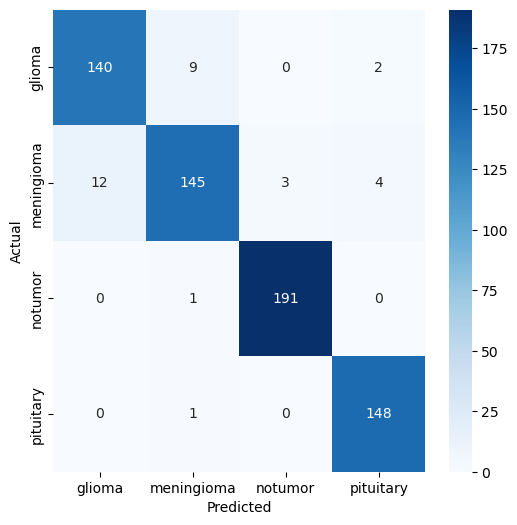

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return fig

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

fig = plot_confusion_matrix(y_true, y_pred, classes=label_encoder.classes_)
writer.add_figure("Confusion Matrix", fig)


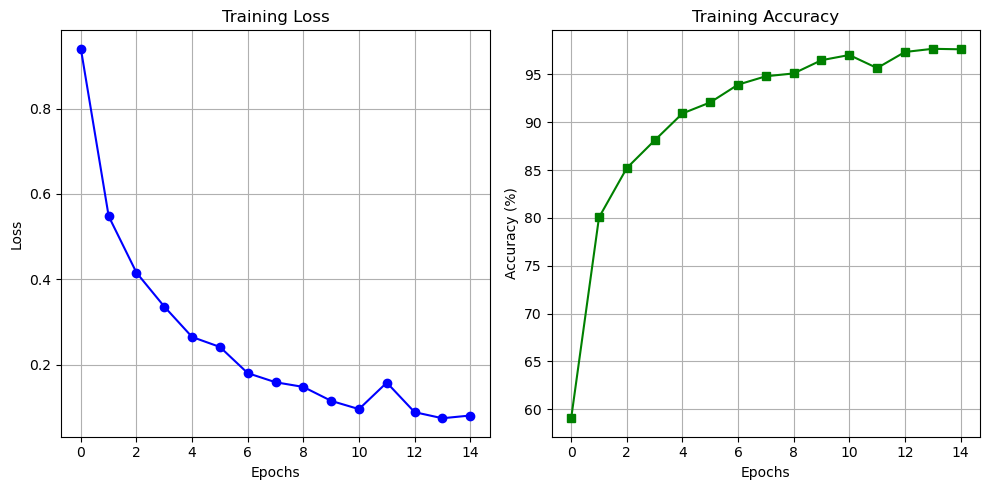

In [124]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Load the TensorBoard event file
event_acc = EventAccumulator("runs/cnn1/")  # Change path if needed
event_acc.Reload()

# Extract scalar data
loss_data = event_acc.Scalars("Training Loss/Epoch")
acc_data = event_acc.Scalars("Training Accuracy/Epoch")

# Get steps (epochs) and values
epochs = [entry.step for entry in loss_data]
loss_values = [entry.value for entry in loss_data]
acc_values = [entry.value for entry in acc_data]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.savefig("Loss.png")

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, marker='s', linestyle='-', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid()
plt.savefig("Accuracy.png")
# Show both plots
plt.tight_layout()
plt.show()


In [125]:
torch.save(model.state_dict(), "brain_tumor_model.pth")


In [ ]:
!tensorboard --logdir=runs/cnn1
